## Import Libraries and Files

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files,drive
import zipfile
import seaborn as sns
# !pip install geopandas
import geopandas as gpd
from shapely.geometry import Point, Polygon
# !pip install descartes
from descartes import PolygonPatch

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
files.upload()
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d etiennelq/french-employment-by-town

french-employment-by-town.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
datasets = zipfile.ZipFile('french-employment-by-town.zip')
datasets.extractall('src')

 ## Read Files & Data Preprocessing

In [0]:
population_df = pd.read_csv('src/population.csv')
        
firm_df= pd.read_csv('src/base_etablissement_par_tranche_effectif.csv')

town_df = pd.read_csv('src/name_geographic_information.csv')

salary_df = pd.read_csv("src/net_salary_per_town_categories.csv")

department_df = gpd.read_file("src/departements.geojson")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# processing town_df, especially longitude column
town_df['longitude'] = town_df['longitude'].apply(lambda x:str(x).replace(',','.'))
town_df.drop(town_df[town_df['longitude']=='-'].index,inplace= True)
town_df.dropna(subset=['latitude','longitude'],inplace=True)
town_df["longitude"] = town_df["longitude"].astype(float)

In [0]:
firm_df = firm_df[firm_df["CODGEO"].apply(lambda x: str(x).isdigit())]
firm_df['CODGEO'] = firm_df['CODGEO'].astype(int)
    
salary_df = salary_df[salary_df["CODGEO"].apply(lambda x: str(x).isdigit())]
salary_df['CODGEO'] = salary_df['CODGEO'].astype(int)

population_df = population_df[population_df["CODGEO"].apply(lambda x: str(x).isdigit())]
population_df['CODGEO'] = population_df['CODGEO'].astype(int)
population_df = population_df.drop(['LIBGEO',"NIVGEO"],axis=1)

## EDA on salary data

In [0]:
salary_df.describe()

,CODGEO,SNHM14,SNHMC14,SNHMP14,SNHME14,SNHMO14,SNHMF14,SNHMFC14,SNHMFP14,SNHMFE14,...,SNHMHO14,SNHM1814,SNHM2614,SNHM5014,SNHMF1814,SNHMF2614,SNHMF5014,SNHMH1814,SNHMH2614,SNHMH5014
count,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,...,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000,5107.000000
mean,52531.824946,13.712551,23.711886,14.571843,10.566379,11.238712,12.042295,20.226376,13.274878,10.310456,...,11.501547,9.549501,13.502330,15.882671,9.162581,12.060329,13.175798,9.819405,14.493793,17.688154
std,25781.402402,2.562868,2.836451,1.487597,0.812953,1.224076,1.790723,2.327173,0.990423,0.748591,...,1.291991,0.997259,2.365774,3.591603,0.453437,1.827818,2.252915,1.538884,2.855326,4.536457
min,1004.000000,10.200000,16.000000,11.600000,8.700000,8.300000,9.300000,12.000000,10.600000,8.700000,...,8.900000,7.900000,9.700000,10.500000,7.500000,9.100000,9.500000,7.800000,9.600000,10.800000
25%,33036.500000,12.100000,21.900000,13.800000,10.000000,10.600000,10.900000,18.800000,12.600000,9.800000,...,10.800000,9.200000,12.000000,13.700000,8.900000,10.900000,11.700000,9.400000,12.700000,14.900000
50%,56132.000000,13.000000,23.200000,14.400000,10.400000,11.000000,11.500000,20.000000,13.100000,10.100000,...,11.300000,9.500000,12.900000,15.000000,9.100000,11.600000,12.600000,9.700000,13.800000,16.600000
75%,74088.000000,14.500000,24.900000,15.100000,10.900000,11.600000,12.700000,21.400000,13.800000,10.600000,...,11.900000,9.700000,14.300000,16.900000,9.400000,12.700000,14.000000,10.000000,15.500000,19.000000
max,97424.000000,43.300000,51.500000,54.600000,17.500000,46.300000,26.700000,35.500000,19.000000,16.100000,...,53.200000,60.600000,38.100000,56.900000,12.000000,26.600000,31.000000,93.300000,45.400000,68.600000


[Text(0, 0, '18-25'), Text(0, 0, '26-50'), Text(0, 0, '>50')]

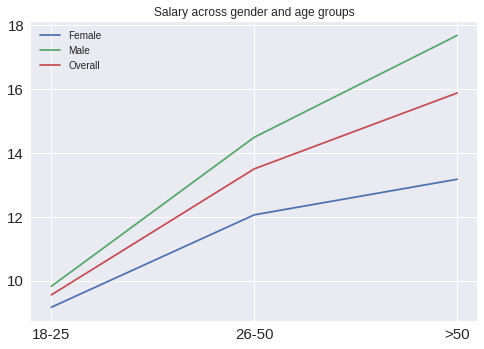

In [0]:
# salary acrosses gender & age
# [overall 18-25, o26-50, o>50, female 18-25, f26-50, f>50, male 18-25, m26-50, m>50]
avg_gender_age_salary = [salary_df[x].mean() for x in salary_df.columns[17:]]

index = ['18-25','26-50','>50']

gender_age_df = pd.DataFrame({
    'Overall':avg_gender_age_salary[:3],
    'Female':avg_gender_age_salary[3:6],
    'Male':avg_gender_age_salary[6:]},index=index)

gender_age_plot = gender_age_df.plot.line(rot=0,title='Salary across gender and age groups',fontsize = 15)
gender_age_plot.set_xticks(np.arange(len(index)))
gender_age_plot.set_xticklabels(index)

Findings:
*   We can see that Males always earn a higher salary than Females
*   The salary gap across genders increases with age
*  As females gets older, the increase in their salary is much lower compared to that of males, suggesting that females may tend not to move up the management laddler while males tends to.


---

Hypothesis:
> As one gets older, he/she tends to move up the ladder in a company and thus earns a higher salary. Since the salary gap across genders increases with age, it should also increase across the postitions, from normal workers to executives.



[Text(0, 0, 'Worker'),
 Text(0, 0, 'Employee'),
 Text(0, 0, 'Middle Manager'),
 Text(0, 0, 'Executive')]

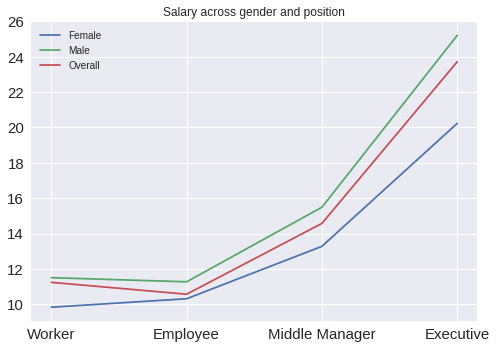

In [0]:
# salary acrosses gender & position
overall = [salary_df[x].mean() for x in salary_df.columns[6:2:-1]]
female = [salary_df[x].mean() for x in salary_df.columns[11:7:-1]]
male = [salary_df[x].mean() for x in salary_df.columns[16:12:-1]]

index = ['Worker','Employee','Middle Manager','Executive']

gender_position_df = pd.DataFrame({
    'Overall':overall,
    'Female':female,
    'Male':male},index=index)

gender_pos_plot = gender_position_df.plot.line(rot=0,title='Salary across gender and position',fontsize=15)
gender_pos_plot.set_xticks(np.arange(len(index)))
gender_pos_plot.set_xticklabels(index)

Finding:

* The hypotheis is valid as the salary gap across genders increases from employees to middle managers to executives.
* The gradient of the graph / rate of increase is higher between higher managment positions than that between lower management positions.
* However, it is interesting to see that the salary gap across genders of workers is larger than that of employees



/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


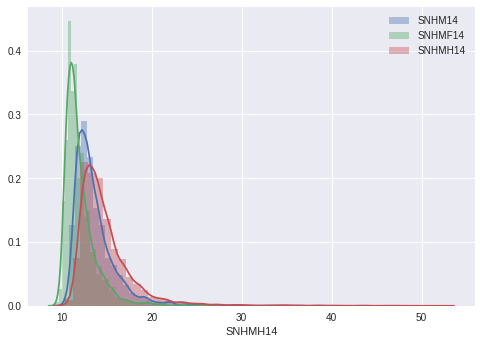

In [0]:
# plot distribution of overall mean salary, overall female mean salary and overall male mean salary

sns.set(color_codes=True)
avg_salary_df = salary_df[['SNHM14','SNHMF14','SNHMH14']]

for col in avg_salary_df.columns:
    sns.distplot(avg_salary_df[col],label=col)
plt.legend()

## EDA on firm data

In [0]:
firm_df.describe()

,CODGEO,REG,E14TST,E14TS0ND,E14TS1,E14TS6,E14TS10,E14TS20,E14TS50,E14TS100,E14TS200,E14TS500
count,36321.000000,36321.000000,36321.000000,36321.000000,36321.000000,36321.000000,36321.000000,36321.000000,36321.000000,36321.000000,36321.000000,36321.000000
mean,46521.041051,48.973459,123.721704,83.713829,27.346659,5.237218,3.814956,2.308004,0.743317,0.334627,0.174197,0.048897
std,25513.105550,25.185044,2364.619186,1738.182920,434.069122,84.078419,61.250534,32.753222,9.929839,4.873106,2.797187,1.096414
min,1001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25269.000000,25.000000,8.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,49159.000000,43.000000,19.000000,14.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,67106.000000,73.000000,54.000000,39.000000,11.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,97617.000000,93.000000,427385.000000,316603.000000,76368.000000,14836.000000,10829.000000,5643.000000,1658.000000,812.000000,456.000000,180.000000


In [0]:
firm_size_mean_salary = pd.DataFrame(columns = salary_df.columns[2:])

In [0]:
firm_size_mean_salary['firm_size'] = firm_df.columns[6:]

for col in firm_size_mean_salary.columns[:-1]:
    firm_size_mean_salary[col] = [salary_df.loc[salary_df['CODGEO'].isin(firm_df.loc[firm_df[row]>0]['CODGEO'])][col].mean() for row in firm_size_mean_salary['firm_size']]

In [0]:
firm_size_mean_salary

,SNHM14,SNHMC14,SNHMP14,SNHME14,SNHMO14,SNHMF14,SNHMFC14,SNHMFP14,SNHMFE14,SNHMFO14,...,SNHM1814,SNHM2614,SNHM5014,SNHMF1814,SNHMF2614,SNHMF5014,SNHMH1814,SNHMH2614,SNHMH5014,firm_size
0,13.711908,23.710830,14.571641,10.566295,11.238700,12.041774,20.225460,13.274677,10.310341,9.831982,...,9.549471,13.501782,15.881767,9.162495,12.059851,13.175108,9.819409,14.493165,17.686996,E14TS1
1,13.710911,23.716326,14.571811,10.565523,11.236560,12.041361,20.228169,13.274350,10.310335,9.827792,...,9.550347,13.500179,15.882543,9.163261,12.059175,13.176215,9.820313,14.490855,17.688177,E14TS6
2,13.699696,23.711984,14.565709,10.563765,11.228097,12.037551,20.228117,13.273603,10.309939,9.823826,...,9.549737,13.488684,15.872753,9.162652,12.054737,13.174534,9.820405,14.475870,17.677814,E14TS10
3,13.702306,23.729831,14.566090,10.562460,11.225496,12.041405,20.233718,13.277621,10.311873,9.822528,...,9.545142,13.491587,15.880760,9.166410,12.058574,13.181358,9.810741,14.476425,17.690540,E14TS20
4,13.746571,23.818925,14.573866,10.576998,11.216577,12.089390,20.315713,13.303996,10.329914,9.802079,...,9.558423,13.532559,15.961231,9.183450,12.109395,13.247165,9.824244,14.514390,17.793763,E14TS50
5,13.749325,23.799365,14.561111,10.585000,11.182976,12.124643,20.349087,13.323333,10.347897,9.787222,...,9.592302,13.542302,15.990873,9.210675,12.153651,13.300754,9.865079,14.495119,17.820635,E14TS100
6,13.867389,23.874230,14.611688,10.621893,11.229076,12.241847,20.493101,13.386830,10.392930,9.821494,...,9.618871,13.653250,16.173375,9.246009,12.273261,13.465051,9.890365,14.599544,18.012600,E14TS200
7,14.393797,24.221785,14.832073,10.740393,11.377912,12.681846,20.829955,13.584266,10.531619,9.946293,...,9.780484,14.161725,16.964297,9.381089,12.723903,14.060666,10.082905,15.144478,18.954766,E14TS500


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


[Text(0, 0, 'E14TS1'),
 Text(0, 0, 'E14TS6'),
 Text(0, 0, 'E14TS10'),
 Text(0, 0, 'E14TS20'),
 Text(0, 0, 'E14TS50'),
 Text(0, 0, 'E14TS100'),
 Text(0, 0, 'E14TS200'),
 Text(0, 0, 'E14TS500')]

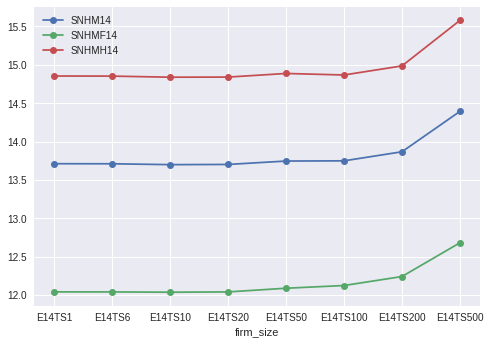

In [0]:
# firm_size vs mean salary across genders
mean_salary_plot = firm_size_mean_salary.plot(x='firm_size', y=['SNHM14','SNHMF14','SNHMH14'], linestyle='-', marker='o')
# ensure the first label is shown
mean_salary_plot.set_xticks(np.arange(len(firm_size_mean_salary['firm_size'])))
mean_salary_plot.set_xticklabels(firm_size_mean_salary['firm_size'])

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


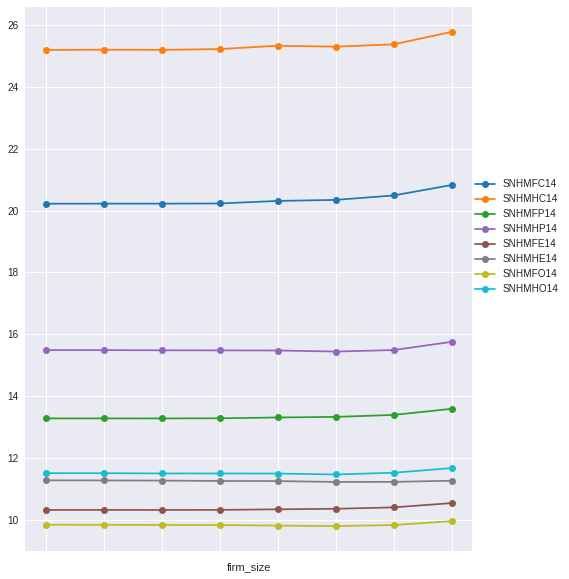

In [0]:
ax = firm_size_mean_salary.plot(x='firm_size', y=['SNHMFC14','SNHMHC14','SNHMFP14','SNHMHP14','SNHMFE14','SNHMHE14','SNHMFO14','SNHMHO14'], 
                      linestyle='-', marker='o',colormap='tab10',figsize=(8,10))
ax.legend(loc='upper center', bbox_to_anchor=(1.1, 0.7), shadow=True, ncol=1)

Hypothesis:
> firms with more employees are larger and thus more profitable. Therefore, towns with larger firms should have a higher mean salary (overall and across genders and across postitions).


Result/Findings:
* There is a rather significant increase in terms of mean salary (overall and across genders), and the rate of increase is higher as the firm size increases. The hypothesis is rather valid.

* The salary gap across genders does not increase much in towns with larger firms.
* The diagram furthers supports the findings in the previous section where the salary gap across genders is higher in higher management positions than that in lower management positions.

In [0]:
salary_firm_df = salary_df.merge(firm_df,how='left',left_on='CODGEO',right_on='CODGEO')

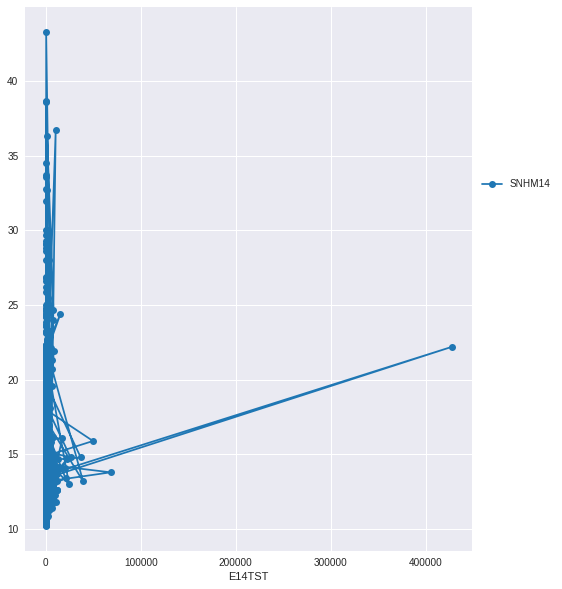

In [0]:
ax = salary_firm_df.plot(x='E14TST', y='SNHM14', 
                      linestyle='-', marker='o',colormap='tab10',figsize=(8,10))
ax.legend(loc='upper center', bbox_to_anchor=(1.1, 0.7), shadow=True, ncol=1)

As the graph is very distorted due to outliers, I will remove the top 10 and bottom 10 as outliers

In [0]:
for i in range(10):
    max_outlier = salary_firm_df.loc[salary_firm_df['E14TST']==salary_firm_df['E14TST'].max()]
    min_outlier = salary_firm_df.loc[salary_firm_df['E14TST']==salary_firm_df['E14TST'].min()]
    salary_firm_df = salary_firm_df.drop(max_outlier.index)
    salary_firm_df = salary_firm_df.drop(min_outlier.index)

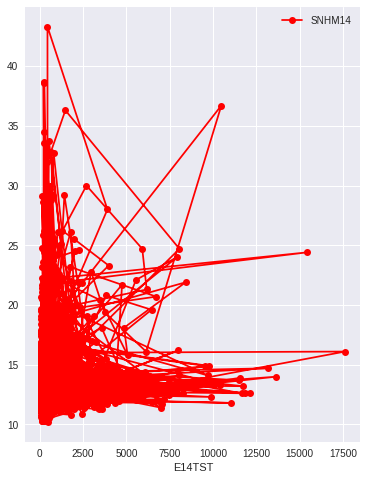

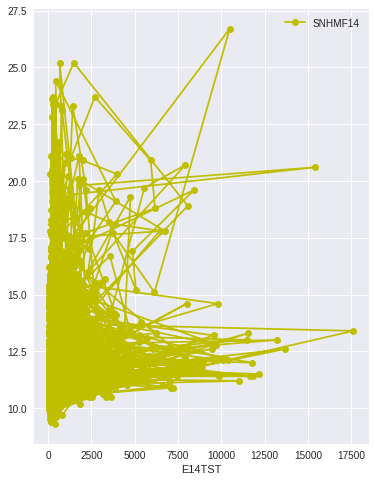

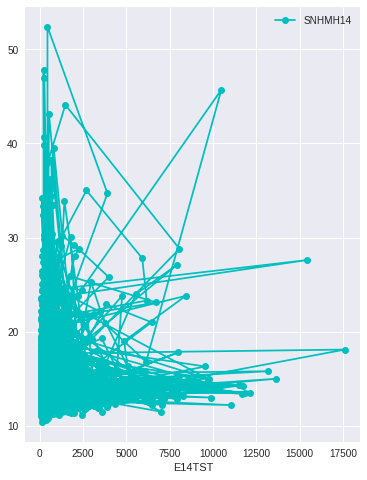

In [0]:
ax_overall = salary_firm_df.plot(x='E14TST', y='SNHM14', 
                      linestyle='-', marker='o',color='r',figsize=(6,8))
ax_female = salary_firm_df.plot(x='E14TST', y='SNHMF14', 
                      linestyle='-', marker='o',color='y',figsize=(6,8))
ax_male = salary_firm_df.plot(x='E14TST', y='SNHMH14', 
                      linestyle='-', marker='o',color='c',figsize=(6,8))


Overall finding:


*   There is a siginificant gender inequality in terms of earnings. The higher the positions in a company, especially in larger companies, the worse the inequality is (i.e. the larger the earning gap between males and females is).
* The wage gap across positions is also alarming,  and the gap is even larger for males than females
*   Such gender inequality is also observed with ages, potentially due to the high correlation between age and position levels.




## EDA on Population data

In [0]:
def plot_corr_with_salary(factor):
    '''
    factors will be among AGEQ80_17, SEXE, MOCO
    '''
    global population_df
    global salary_df
    
    # only consider those who are of the working age
    population_df = population_df.drop(population_df[population_df.AGEQ80_17<20].index,axis=0)
    
    other_factors = ['AGEQ80_17','SEXE',"MOCO"]
    other_factors.remove(factor)
    # group by CODGEO and the factor, remove columns of other 2 factors
    groupBy_factor = population_df.groupby(["CODGEO",factor],as_index=False).sum()
    groupBy_factor = groupBy_factor.drop(other_factors,axis =1)
    
    # merge with salary_df and clean up the df
    factor_salary_df = groupBy_factor.merge(salary_df,how='left',left_on='CODGEO',right_on='CODGEO')
    factor_salary_df.dropna(subset=['SNHM14'],inplace=True)
    factor_salary_df = factor_salary_df.drop(['LIBGEO'],axis=1)
    
    factor_salary_df = factor_salary_df.drop(factor_salary_df[factor_salary_df.NB==0].index,axis=0)
    
    # plot corr matrix
    fig, ax = plt.subplots(figsize=(40,40))      
    sns.heatmap(factor_salary_df.corr(),linecolor='white',cmap='RdBu',annot=True,ax=ax)
    
    

In [0]:
plot_corr_with_salary('SEXE')

In [0]:
plot_corr_with_salary('MOCO')

In [0]:
plot_corr_with_salary('AGEQ80_17')

Finding:
* No correlation between Age/MOCO/Gender and Salary

## Correlation Matrix

### Correlation Matrix among Gender, Position and Salaries

In [0]:
# reformat all datasets and merge them into one for regression model
# the dataset should be structured like code, gender, postion, age_group, firm_size
# each town has one code, 2 gender, 4 positions, 3 age groups, 8 firm size

gender_pos_dict={}
gender_pos_dict["SNHMFC14"] = {"gender": 1, "position": 4}
gender_pos_dict["SNHMFP14"] = {"gender": 1, "position": 3}
gender_pos_dict["SNHMFE14"] = {"gender": 1, "position": 2}
gender_pos_dict["SNHMFO14"] = {"gender": 1, "position": 1}
gender_pos_dict["SNHMHC14"] = {"gender": 2, "position": 4}
gender_pos_dict["SNHMHP14"] = {"gender": 2, "position": 3}
gender_pos_dict["SNHMHE14"] = {"gender": 2, "position": 2}
gender_pos_dict["SNHMHO14"] = {"gender": 2, "position": 1}

# compile with gender_position
gp_compiled_data = []
for index, row in salary_df.iterrows():
    for key, value in gender_pos_dict.items(): 
        row_dict = {}
        row_dict["CODGEO"] = row["CODGEO"]
        row_dict["gender"] = value["gender"]
        row_dict["position"] = value["position"]
        row_dict["salary"] = row[key]
        gp_compiled_data.append(row_dict)

In [0]:
gp_compiled_df = pd.DataFrame(gp_compiled_data)

In [0]:
gp_compiled_df = gp_compiled_df.merge(firm_df,how='left',left_on='CODGEO',right_on='CODGEO')

In [0]:
gp_compiled_df = gp_compiled_df.drop(['LIBGEO',"REG","DEP"],axis=1)

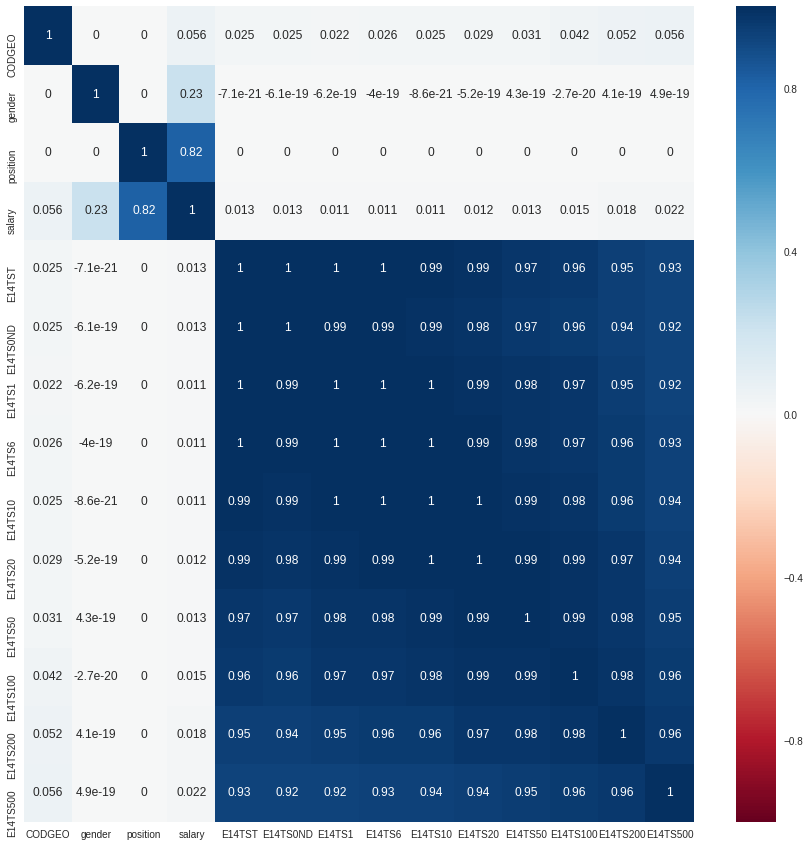

In [0]:
fig, ax = plt.subplots(figsize=(15,15))      
sns.heatmap(gp_compiled_df.corr(),linecolor='white',cmap='RdBu',annot=True,ax=ax)

Finding:
* As firm size increases, the correlation with salary also increases, supporting the hypothesis that towns larger firms tend to have a higher mean salary
* Position is siginificantly correlated to salary
* Gender is correlated to salary but the correlation is not very strong. Thus, there may be a possible interaction term of gender*position with salary, since we found that at the same position, males are earning more and the wage differential across genders increases with higher positions.


### Correlation Matrix: Adding an Interaction Term: Gender_Position

In [0]:
gp_compiled_df['gender_position']=gp_compiled_df['gender'] * gp_compiled_df['position']

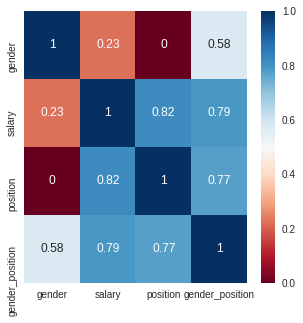

In [0]:
fig, ax = plt.subplots(figsize=(5,5))  

sns.heatmap(gp_compiled_df[['gender','salary','position','gender_position']].corr(),linecolor='white',cmap='RdBu',annot=True,ax=ax)

As we can, gender_position has a much higher correlation to salary than gender. However, position still has a higher correlation.

## Regression Model

So far, I have discovered the following relationships regarding salary:

One's salary will be higher if he is/has
*   Male
*   Higher position
*   Higher Age
*   Larger Firm

As such, the four independent variables are:
* gender 
* position 
* age
* firm size 

(One's location (town) will definitely affect but it is too complicated to think for now)

There may be interactions among the indepent variables as well

### reg model building function

In [0]:
def build_reg_model(testSize,df,need_output=False):
    X = df.iloc[:, :-1].values
    y = df.iloc[:,-1].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize, random_state = 0)
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    
    coefficients = {df.columns[x]:reg.coef_[x] for x in range(len(df.columns)-1)}
    if need_output:
        return coefficients, r2_score(y_test, y_pred),mean_squared_error(y_test, y_pred),X_train, X_test, y_train, y_test,y_pred
    return coefficients, r2_score(y_test, y_pred),mean_squared_error(y_test, y_pred)

### Regression Model Without Interaction Terms

In [0]:
all_compiled_df = gp_compiled_df.copy()
all_compiled_df = all_compiled_df.drop(['gender_position'],axis=1)

In [0]:
all_compiled_df = all_compiled_df.merge(population_df,how='left',left_on='CODGEO',right_on='CODGEO')

In [0]:
all_compiled_df = all_compiled_df.dropna(subset= ["NB"],axis=0)
all_compiled_df = all_compiled_df.drop(["CODGEO"],axis = 1)

In [0]:
all_compiled_df[["MOCO","SEXE","AGEQ80_17","NB"]]=all_compiled_df[["MOCO","SEXE","AGEQ80_17","NB"]].astype(int)

In [0]:
# re-arrange for train_test split
salary_col = all_compiled_df['salary']
all_compiled_df = all_compiled_df.drop(['salary'],axis=1)
all_compiled_df['salary'] = salary_col

In [0]:
coef, r2, mse = build_reg_model(0.25, all_compiled_df)

In [0]:
coef

{'AGEQ80_17': -3.3367250367512605e-05,
 'E14TS0ND': 130577504.24358228,
 'E14TS1': 130577504.24190871,
 'E14TS10': 130577504.22577624,
 'E14TS100': 130577504.2427278,
 'E14TS20': 130577504.25145362,
 'E14TS200': 130577504.27351603,
 'E14TS50': 130577504.25726919,
 'E14TS500': 130577504.32793055,
 'E14TS6': 130577504.24696133,
 'E14TST': -130577504.24315979,
 'MOCO': -5.5259365314874916e-06,
 'NB': 6.42048637356854e-05,
 'SEXE': -0.00017991898842902748,
 'gender': 2.455474194262294,
 'position': 3.9770141280688813}

In [0]:
print("R square value is:",r2)
print("mean squared error is:",mse)

R square value is: 0.719569545216699
mean squared error is: 8.310305681558525


Find the best train_test size 

In [0]:
for i in range(5,55,5):
    coef, r2, mse = build_reg_model(i/100,all_compiled_df)
    print("test_size =",i/100)
    print("R square value is:",r2)
    print("mean squared error is:", mse)
    print("----------------------------------------------------------")

test_size = 0.05
R square value is: 0.7178688696366473
mean squared error is: 8.33764381668396
----------------------------------------------------------
test_size = 0.1
R square value is: 0.7185668850370484
mean squared error is: 8.340033330694428
----------------------------------------------------------
test_size = 0.15
R square value is: 0.7195612072916265
mean squared error is: 8.308574013840655
----------------------------------------------------------
test_size = 0.2
R square value is: 0.7199637899831478
mean squared error is: 8.296937063663824
----------------------------------------------------------
test_size = 0.25
R square value is: 0.719569545216699
mean squared error is: 8.310305681558525
----------------------------------------------------------
test_size = 0.3
R square value is: 0.719641732427087
mean squared error is: 8.308014718634952
----------------------------------------------------------
test_size = 0.35
R square value is: 0.7198318297566922
mean squared error is

In [0]:
# changing test size does not improve on r2 or mse much, so we just take it as 0.20 and plot residual
result = build_reg_model(0.20,all_compiled_df,True)

In [0]:
residual = result[-2] - result[-1]
x_axis = np.arange(len(residual))

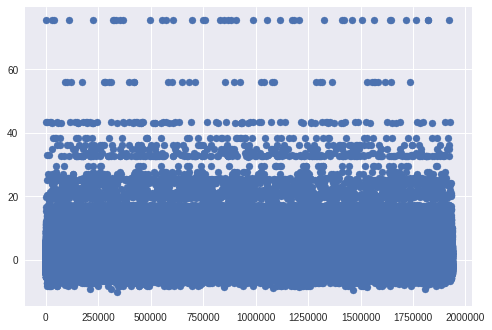

In [0]:
plt.scatter(x_axis,residual)
plt.show()

The residuals are not randomly scattered, suggesting possible other relationships. 

Thus, I move on to try adding interaction terms

### Regression model with Interaction terms

#### Interaction Term is Gender_Position

In [0]:
all_compiled_df = gp_compiled_df.copy()
all_compiled_df = all_compiled_df.merge(population_df,how='left',left_on='CODGEO',right_on='CODGEO')
all_compiled_df = all_compiled_df.dropna(subset= ["NB"],axis=0)
all_compiled_df[["MOCO","SEXE","AGEQ80_17","NB"]]=all_compiled_df[["MOCO","SEXE","AGEQ80_17","NB"]].astype(int)

salary_col = all_compiled_df['salary']
all_compiled_df = all_compiled_df.drop(['salary'],axis=1)
all_compiled_df['salary'] = salary_col

all_compiled_df = all_compiled_df.drop(["CODGEO"],axis = 1)

In [0]:
coefficients, r2, mse = build_reg_model(0.20,all_compiled_df)

In [0]:
coefficients

{'AGEQ80_17': -4.079129678118103e-05,
 'E14TS0ND': -0.011834324990701103,
 'E14TS1': -0.01351445121320616,
 'E14TS10': -0.029618560873238258,
 'E14TS100': -0.012667392045527508,
 'E14TS20': -0.0039648456767382425,
 'E14TS200': 0.0182618320705134,
 'E14TS50': 0.0019193952522860646,
 'E14TS500': 0.07211113981642911,
 'E14TS6': -0.008435900520103968,
 'E14TST': 0.012256891818406706,
 'MOCO': 6.0628476847482124e-05,
 'NB': 6.38554877373239e-05,
 'SEXE': 0.00012832108510288102,
 'gender': -0.3436277175544117,
 'gender_position': 1.119405314676717,
 'position': 2.297720596505089}

In [0]:
print("R square value is:",r2)
print("mean squared error is:",mse)

R square value is: 0.7331939068982928
mean squared error is: 7.904954014817155


Adding an interaction term of gender_position improves on the r2 and mse

Now I try to add another one, which is age_position

#### add another interaction term of Age_Position

In [0]:
all_compiled_df['age_position'] = all_compiled_df['AGEQ80_17'] * all_compiled_df["position"]

In [0]:
salary_col = all_compiled_df['salary']
all_compiled_df = all_compiled_df.drop(['salary'],axis=1)
all_compiled_df['salary'] = salary_col

In [0]:
coefficients, r2, mse = build_reg_model(0.20,all_compiled_df)

In [0]:
coefficients

{'AGEQ80_17': -2.344234266238428e-05,
 'E14TS0ND': -0.011834320361266436,
 'E14TS1': -0.013514447677742823,
 'E14TS10': -0.02961855426262688,
 'E14TS100': -0.01266738089468779,
 'E14TS20': -0.00396483930894946,
 'E14TS200': 0.018261865944442273,
 'E14TS50': 0.0019193842924499214,
 'E14TS500': 0.07211107448047444,
 'E14TS6': -0.00843589488708585,
 'E14TST': 0.012256887324302959,
 'MOCO': 6.062515128199002e-05,
 'NB': 6.385566829631819e-05,
 'SEXE': 0.00012840136441905683,
 'age_position': -6.940509875139056e-06,
 'gender': -0.3436275923731917,
 'gender_position': 1.1194052660875846,
 'position': 2.2979982800330445}

In [0]:
print("R square value is:",r2)
print("mean squared error is:",mse)

R square value is: 0.7331938958893987
mean squared error is: 7.904954340989622


Age_position's coefficient is too small and does not improve on r2 values.

Thus, I just discard this factor

## Salary distrbution in different departments

In [0]:
salary_town_df = salary_df.merge(town_df,how='left',left_on='CODGEO',right_on="code_insee")

In [0]:
salary_town_df.dropna(subset=['latitude','longitude'],inplace=True)

In [0]:
# create a df of each dept salary
salary_dept_df = salary_town_df.groupby('numéro_département').mean()

In [0]:
# merge with department_df for plotting 
salary_dept_df['dept_code'] = salary_dept_df.index
salary_dept_geo = gpd.GeoDataFrame(salary_dept_df.merge(department_df,how='left',left_on='dept_code',right_on='code'))

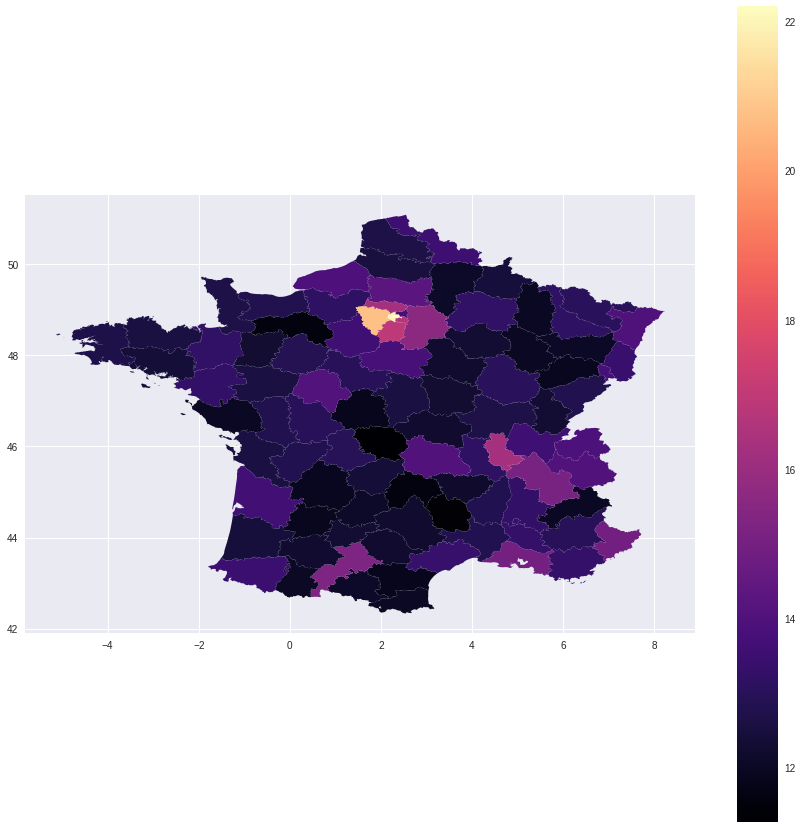

In [0]:
fig,ax = plt.subplots(figsize=(15,15)) 
salary_dept_plot = salary_dept_geo.plot(column='SNHM14',cmap='magma',legend=True,ax=ax)